 Van der Pol’s differential equation is



The equation describes a system with nonlinear damping, the degree of nonlinearity given by μ. If μ = 0 the system is linear and undamped, but as μ increases the strength of the nonlinearity increases.

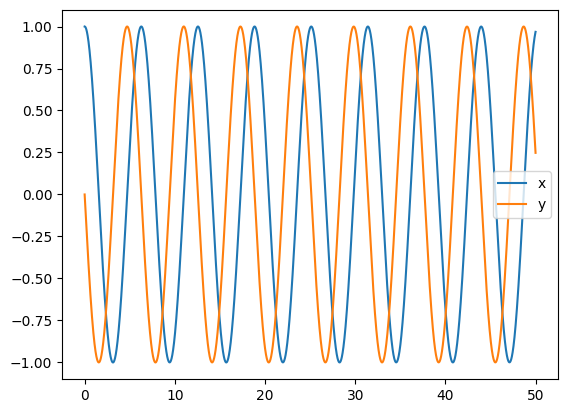

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sympy.codegen.cnodes import sizeof

mu = 0.0

def vdp(t,state):
    x,y = state
    dxdt = y
    dydt = mu*(1-x**2)*y - x
    return [dxdt, dydt]


state0 = [1.0, 0.0]
tspan = (0,50)
t_eval = np.linspace(*tspan,10000)

sol = solve_ivp(vdp, tspan, state0, t_eval=t_eval)

x = sol.y[0]
y = sol.y[1]
t = sol.t

plt.figure()
plt.plot(t_eval, x, label="x")
plt.plot(t_eval, y, label="y")
plt.legend()
plt.show()

In [3]:
data = np.vstack([x,y]).T
data

array([[ 1.        ,  0.        ],
       [ 0.9999875 , -0.00500048],
       [ 0.99994999, -0.01000083],
       ...,
       [ 0.96572767,  0.2574658 ],
       [ 0.96700292,  0.2526331 ],
       [ 0.96825408,  0.24779434]])

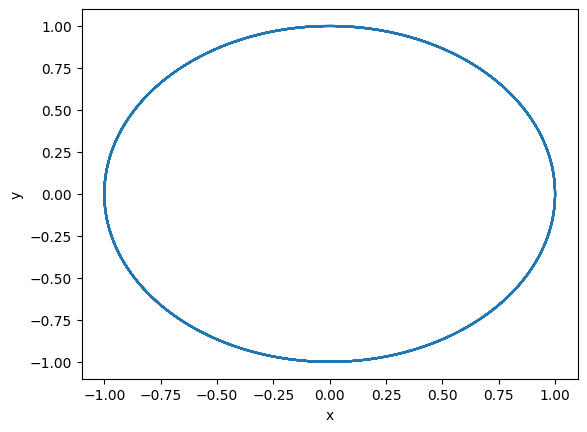

In [4]:
plt.plot(x,y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [15]:
# adding noise to the data
noisy = np.random.normal(0, 0.01, data.shape)
data_noise = data + noisy

data_noise

array([[ 1.00616892, -0.00139929],
       [ 1.01081551, -0.02323544],
       [ 1.00702987, -0.00420175],
       ...,
       [ 0.94831916,  0.2374852 ],
       [ 0.97171108,  0.24867831],
       [ 0.97012326,  0.25869131]])

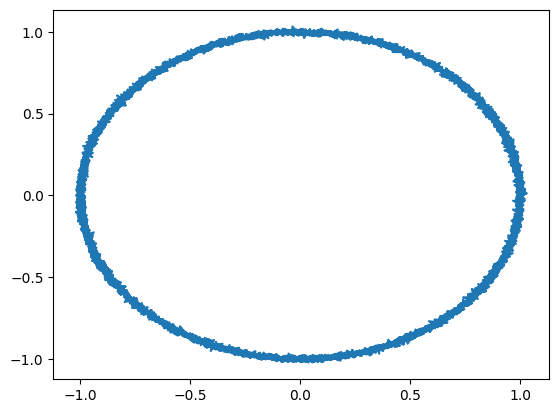

In [16]:
plt.plot(data_noise[:,0], data_noise[:,1])

In [17]:
# Let's build the physics autoencoder
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

tensor = torch.tensor(data_noise, dtype=torch.float32)
dataset = TensorDataset(tensor, tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [24]:

class VanDerPolAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
        )
    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out, latent

model = VanDerPolAE()

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, _ in loader:
        output, latent = model(batch_idx)
        loss = criterion(output, batch_idx)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    if epoch % 10 == 0:
        print(f"Epoch: [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

Epoch: [1/100], Loss: 0.199538
Epoch: [11/100], Loss: 0.000024
Epoch: [21/100], Loss: 0.000022
Epoch: [31/100], Loss: 0.000016
Epoch: [41/100], Loss: 0.000013
Epoch: [51/100], Loss: 0.000010
Epoch: [61/100], Loss: 0.000012
Epoch: [71/100], Loss: 0.000009
Epoch: [81/100], Loss: 0.000007
Epoch: [91/100], Loss: 0.000009


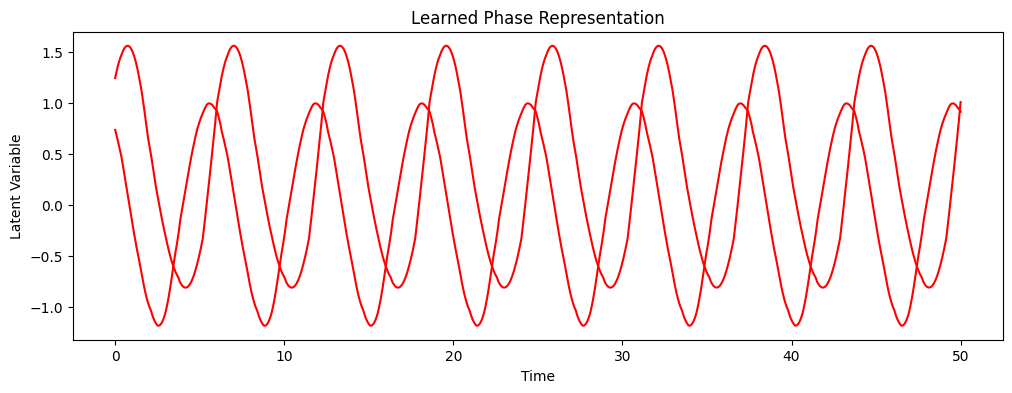

torch.Size([10000, 2])


In [26]:
with torch.no_grad():
    out, latent = model(torch.tensor(data, dtype=torch.float32))


plt.figure(figsize=(12,4))
plt.plot(t, latent, color='red' )
plt.xlabel('Time')
plt.ylabel('Latent Variable')
plt.title('Learned Phase Representation')
plt.show()
print(out.size())

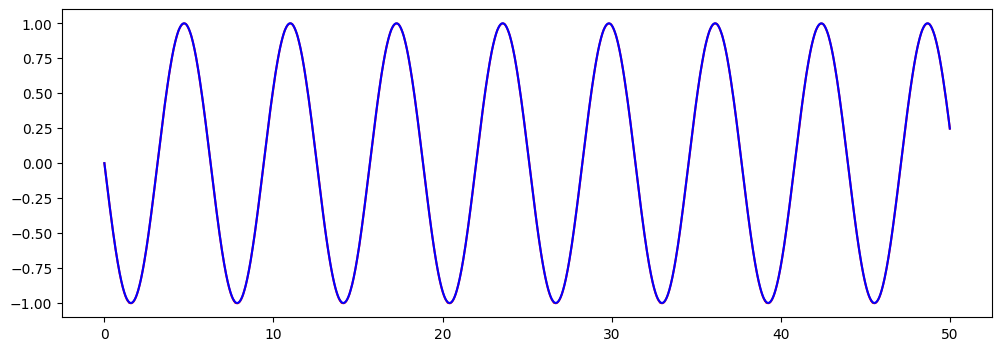

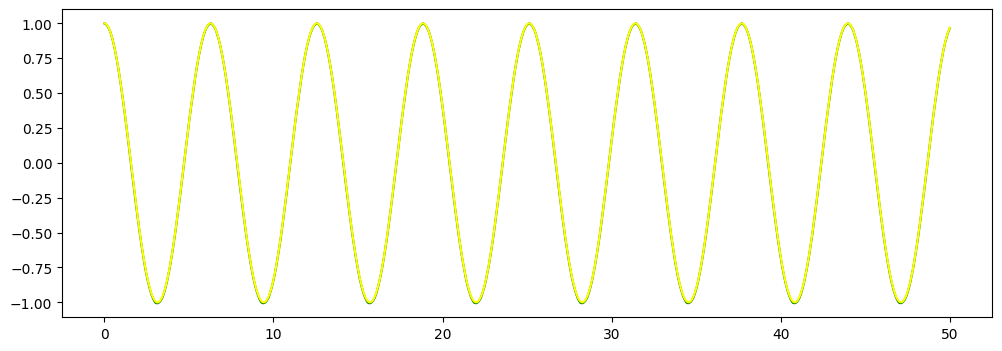

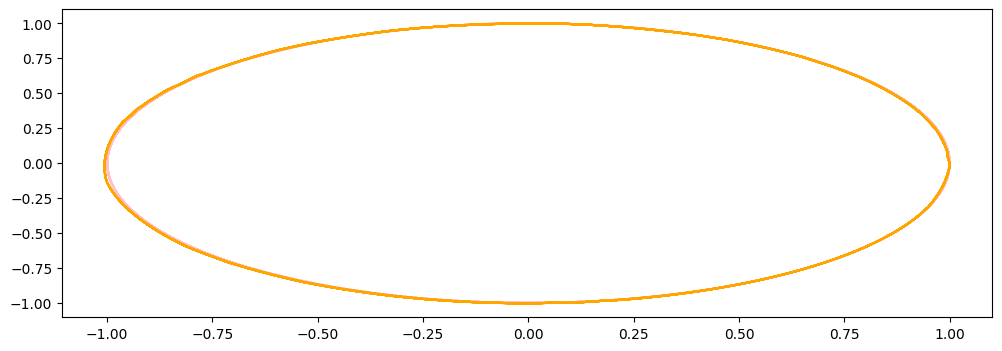

In [27]:
out.numpy()

plt.figure(figsize=(12,4))
plt.plot(t, out[:,1], color='red')
plt.plot(t, y, color='blue')
plt.figure(figsize=(12,4))
plt.plot(t, out[:,0], color='green')
plt.plot(t, x, color='yellow')
plt.figure(figsize=(12,4))
plt.plot(x, y, color='pink')
plt.plot(out[:,0], out[:,1], color='orange')
plt.show()